## Install scME

In [ ]:
#first install scME
!python setup.py install

## scME 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc
import anndata as ad
sc.set_figure_params(figsize=(8, 8))
from scipy.io import mmread

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
import scme

In [3]:
#read the count data matrix of BMNC dataset
#read RNA data
rna_count=mmread('./example_data/rnacountdgc.mtx').toarray()
genes=pd.read_csv("./example_data/genes.csv",index_col=0)
cellids=pd.read_csv("./example_data/cellids.csv",index_col=0)

#read protein data
protein_count=pd.read_csv('./example_data/adtcount.csv',index_col=0)

In [4]:
rna_count=pd.DataFrame(rna_count.T,index=cellids.values[:,0],columns=genes.values[:,0])

In [5]:
#preprocess the data
#create adata object
rna=ad.AnnData(X=rna_count.values,obs=pd.DataFrame(index=rna_count.index), var=pd.DataFrame(index=rna_count.columns))
protein=ad.AnnData(X=protein_count.values,obs=pd.DataFrame(index=protein_count.index), var=pd.DataFrame(index=protein_count.columns))

/opt/miniconda3/envs/scME/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/envs/scME/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  after removing the cwd from sys.path.


In [6]:
# select highly variable genes
rna.layers["counts"] = rna.X.copy()
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes( 
    rna,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset = True
)
rna.raw = rna
rna = rna[:, rna.var.highly_variable]


/opt/miniconda3/envs/scME/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


In [7]:
#PCA and clustering for RNA data
sc.pp.pca(rna,svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=30,n_pcs=30)   
sc.tl.leiden(rna, key_added="rna_leiden",resolution=1)

In [8]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [9]:
protein.layers["counts"] = protein.X.copy()
protein=clr_normalize_each_cell(protein)
sc.pp.pca(protein, svd_solver="arpack")
sc.pp.neighbors(protein, n_neighbors=10) 
sc.tl.leiden(protein, key_added="protein_leiden",resolution=1)

In [22]:
rna.X.shape

(30672, 2000)

In [10]:
#create training dataset
rna.X=rna.layers["counts"]
protein.X=protein.layers["counts"]
traindataset=scme.AnnDataset(rna,protein,to_onehot=True)

In [23]:
#built scme model and initial
#use negative binomial distribution for protein data
model=scme.build_scme(rna,protein,traindataset,protein_dist="NB",if_preprocess=True)

In [24]:
#train the scme model
model=scme.train_model(model,max_epochs=200)

epoch :0000  loss:6514751.65236 loss_ae:5776424.6595 loss_cls:738326.9928
epoch :0001  loss:4612695.50782 loss_ae:4119352.3385 loss_cls:493343.1693
epoch :0002  loss:3719854.26473 loss_ae:3341219.8858 loss_cls:378634.3789
epoch :0003  loss:3096637.08078 loss_ae:2792387.0307 loss_cls:304250.0501
epoch :0004  loss:2527195.01396 loss_ae:2275028.6511 loss_cls:252166.3628
epoch :0005  loss:2098633.11286 loss_ae:1883802.6205 loss_cls:214830.4923
epoch :0006  loss:1766582.44572 loss_ae:1578377.0578 loss_cls:188205.3879
epoch :0007  loss:1491784.39948 loss_ae:1321008.1255 loss_cls:170776.2740
epoch :0008  loss:1247109.55308 loss_ae:1096773.0935 loss_cls:150336.4596
epoch :0009  loss:1052366.39135 loss_ae:913130.4210 loss_cls:139235.9703
epoch :0010  loss:884849.73785 loss_ae:756996.3891 loss_cls:127853.3487
epoch :0011  loss:755204.66203 loss_ae:635933.9592 loss_cls:119270.7029
epoch :0012  loss:642545.33583 loss_ae:532676.6289 loss_cls:109868.7069
epoch :0013  loss:546937.91944 loss_ae:449249

In [25]:
#get the embedding using scme model inference encoder
import torch
rnatorch,proteintorch=torch.from_numpy(np.array(rna.X)),torch.from_numpy(np.array(protein.X))
rnatorch,proteintorch=rnatorch.to(model.device),proteintorch.to(model.device)
model.eval()
zm=model.inference(rnatorch, proteintorch)

In [26]:
rna.obsm["X_scme"]=zm

In [27]:
metadata=pd.read_csv('./example_data/bmmeta.csv',index_col=0)
metadata

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight,cells
a_AAACCTGAGCTTATCG-1,bmcite,7546,2136,1350,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701,a_AAACCTGAGCTTATCG-1
a_AAACCTGAGGTGGGTT-1,bmcite,1029,437,2970,25,HumanHTO1,batch1,T cell,gdT,0.241789,a_AAACCTGAGGTGGGTT-1
a_AAACCTGAGTACATGA-1,bmcite,1111,429,2474,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714,a_AAACCTGAGTACATGA-1
a_AAACCTGCAAACCTAC-1,bmcite,2741,851,4799,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308,a_AAACCTGCAAACCTAC-1
a_AAACCTGCAAGGTGTG-1,bmcite,2099,843,5434,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508,a_AAACCTGCAAGGTGTG-1
...,...,...,...,...,...,...,...,...,...,...,...
b_TTTGTCATCCGAGCCA-1,bmcite,3000,895,5403,25,HumanHTO8,batch2,T cell,CD4 Memory,0.296002,b_TTTGTCATCCGAGCCA-1
b_TTTGTCATCCGTAGGC-1,bmcite,2230,649,4744,25,HumanHTO9,batch2,T cell,CD4 Naive,0.429053,b_TTTGTCATCCGTAGGC-1
b_TTTGTCATCCTCGCAT-1,bmcite,4259,1457,6600,25,HumanHTO6,batch2,Mono/DC,CD16 Mono,0.506296,b_TTTGTCATCCTCGCAT-1
b_TTTGTCATCGCCGTGA-1,bmcite,2648,733,4939,25,HumanHTO3,batch2,T cell,CD4 Naive,0.234427,b_TTTGTCATCGCCGTGA-1


In [29]:
rna.obs["celltype.l1"]=metadata.loc[rna.obs.index,"celltype.l1"]
rna.obs["celltype.l2"]=metadata.loc[rna.obs.index,"celltype.l2"]


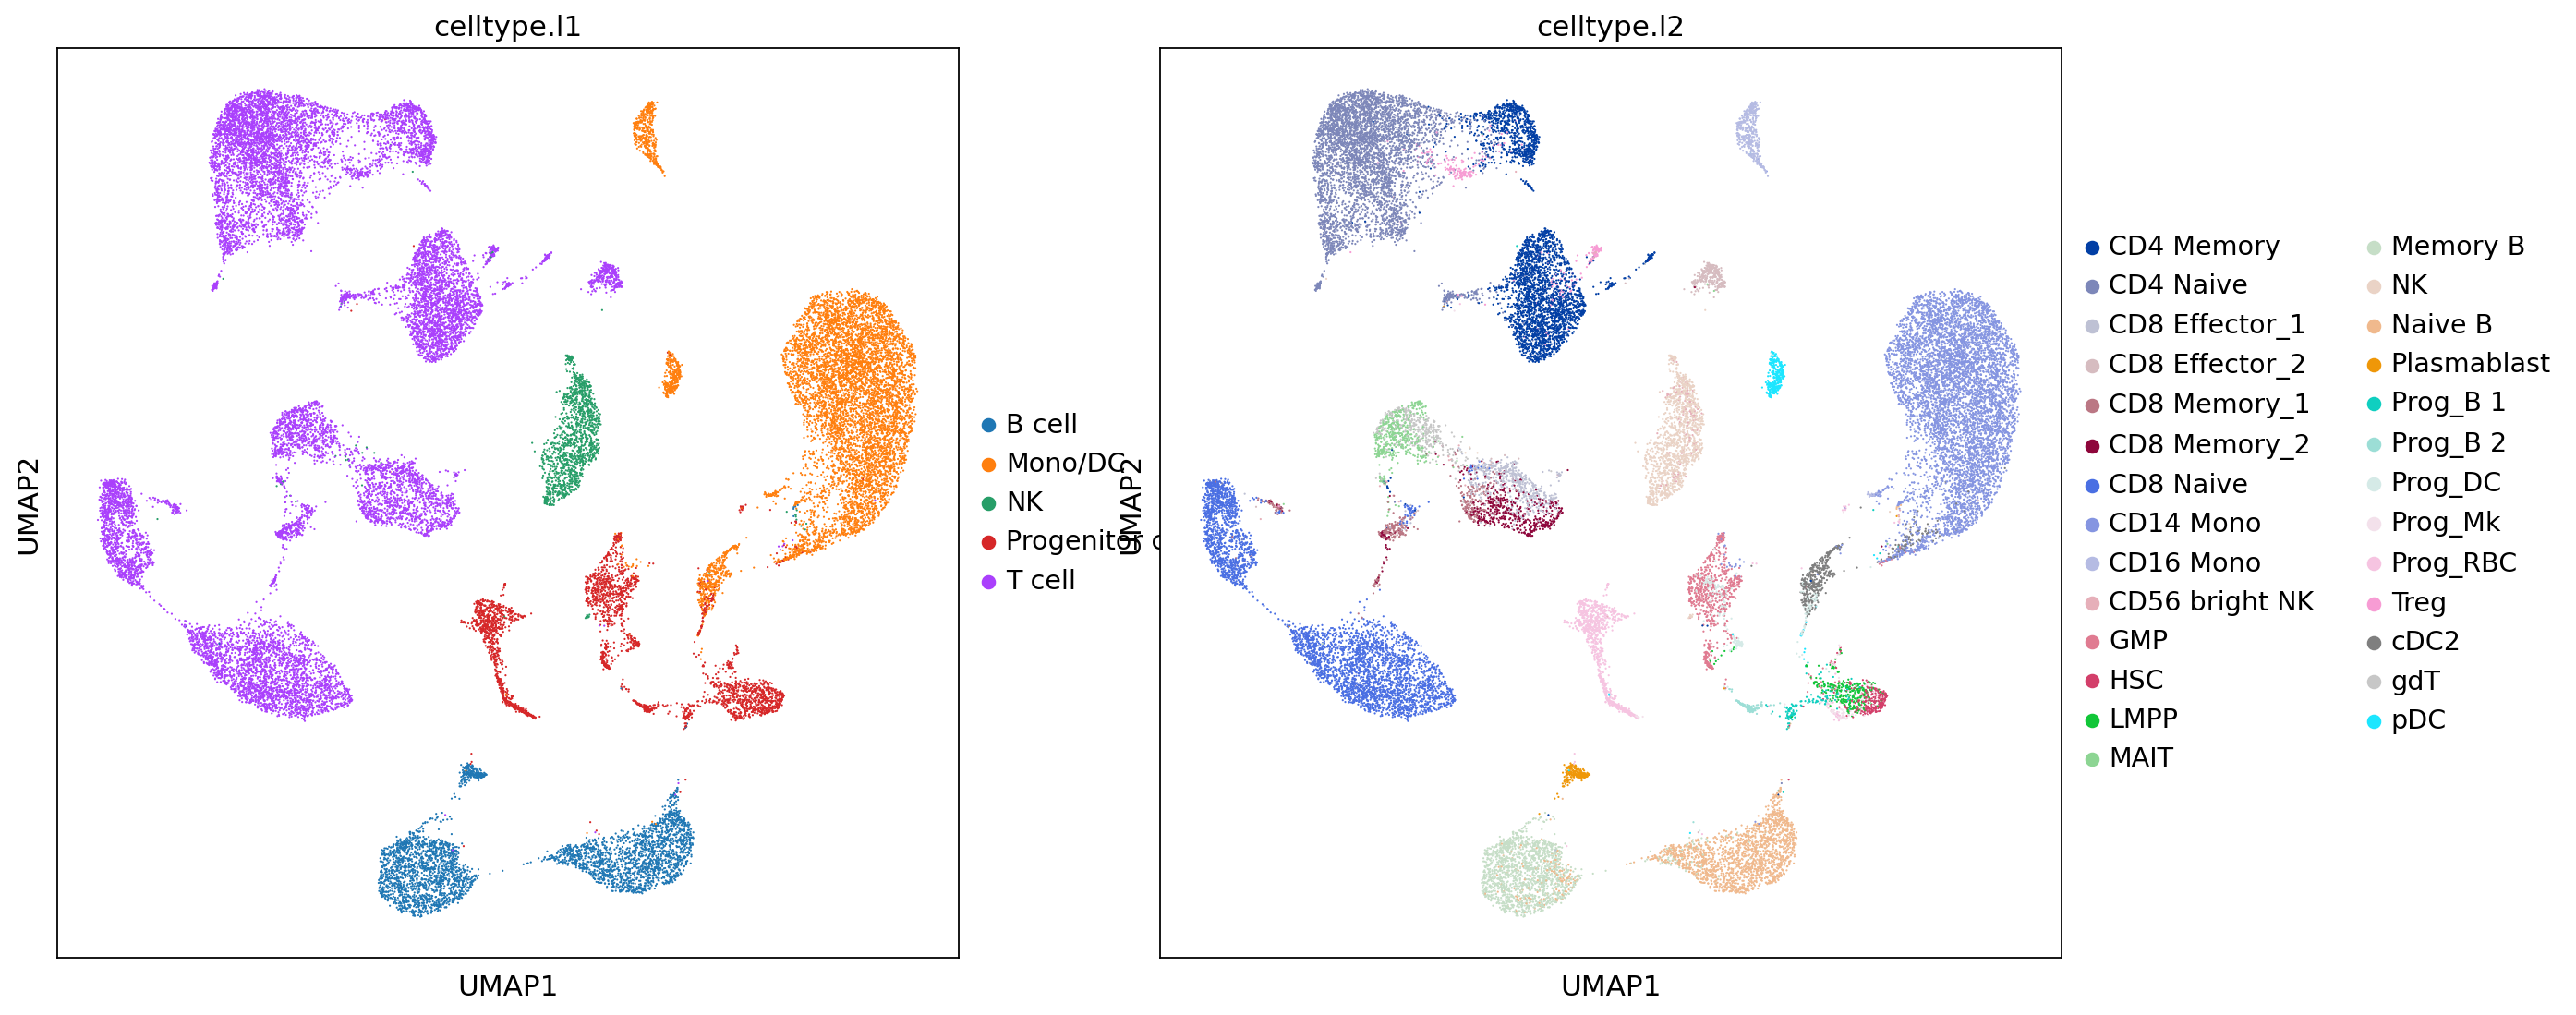

In [30]:
#umap for scme embedding
sc.pp.neighbors(rna, n_neighbors=30,use_rep="X_scme")
sc.tl.umap(rna, min_dist=0.3)
#plot the umap
sc.pl.umap(rna, color=["celltype.l1","celltype.l2"])